## Find depth of upwelling from bottom average concentration on shelf

Look at concentrations near the bottom of the shelf and find the maximum value. This value can be tracked to the original depth it had at the beginning of the simulation.

In [2]:
import cmocean as cmo #cmap=cmo.cm.curl

import matplotlib.pyplot as plt

from math import *

%matplotlib inline

from netCDF4 import Dataset

import numpy as np

import seaborn as sns

import canyon_tools.readout_tools as rout

import canyon_tools.savitzky_golay as sg

In [3]:
def ConcArea(Tr, hfac, ra, bathy, sbdepth=-152.5):
    '''Tr:tracer field (nt,nz,ny,nx)
       hfac: fraction of open cell at center (nz,ny,nx)
       ra: array of cell horizontal areas (ny,nx)
       bathy : depths 2D array from the grid file (ny,nx)
       sbdepth: shelf break depth (negative value)
       
       RETURNS:
       ConcFiltered = concentration at cell closest to bottom(nt,ny,nx)
       Area of domain
       '''
    
    Conc = np.empty((19,360,360))
    ConcFiltered = np.empty((19,360,360))
    Area = np.empty((360,360))
    BottomInd = np.argmax(hfac[::-1,:,:]>0.0,axis=0) # start looking for first no-land cell from the bottom up.
    BottomInd = np.ones(np.shape(BottomInd))*89 - BottomInd # Get index of unreversed z axis
    
    print(np.shape(BottomInd))
    for tt in range(19):
        #print(tt)
        for j in range(360):
            for i in range(360):
                TrBottom = Tr[tt,BottomInd[i,j],i,j]
                Conc[tt,i,j] = TrBottom
                Area[i,j] = ra[i,j]
                
                    
            # Filter step noise
            ConcFiltered[tt,:,j] = sg.savitzky_golay(Conc[tt,:,j], 7,3) 
                
    maskShelf = mask2DCanyon(bathy, sbdepth)
    maskShelf = np.expand_dims(maskShelf,0) # expand along time dimension
    maskShelf = maskShelf + np.zeros(Conc.shape)
    
    return (np.ma.masked_array(ConcFiltered, mask=maskShelf),
            Area)

def mask2DCanyon(bathy, sbdepth=-152.5):
    '''Mask out the canyon from the shelf.
    bathy : depths 2D array from the grid file
    sbdepth: shelf depth, always negative float 
    Returns mask'''
    
    bathyMasked = np.ma.masked_less(-bathy, -152.5)
    return(bathyMasked.mask)



In [4]:
# Seaborn set up
sns.set()
sns.set_style('white')
sns.set_context('notebook')

In [5]:
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run42/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

# Grid variables
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells
rc = CanyonGridOut.variables['RC']
dxg = rout.getField(CanyonGrid, 'dxG') # x coords tracer cells
dyg = rout.getField(CanyonGrid, 'dyG') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')
hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

bathyNoC = rout.getField(CanyonGridNoC, 'Depth')
hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

z = CanyonStateOut.variables['Z']

time = CanyonStateOut.variables['T']

### Define class and save attributes of each run

In [6]:
# Create an empty class to save information of every run

class run:
    pass

In [7]:
#Define all runs, create empty run records
CNTDIFF_kv7 = run()  
CNTDIFF_base = run()
CNTDIFF_kv4 = run()
CNTDIFF_kv3= run()
CNTDIFF_N63 = run()
#CNTDIFF_N39 = run()
#CNTDIFF_N30 = run()
CNTDIFF_N74 = run()
CNTDIFF_N45 = run()
CNTDIFF_f100 = run()
CNTDIFF_f76 = run()
#CNTDIFF_f48 = run()
CNTDIFF_f86 = run()
CNTDIFF_f64 = run()
DIFF3D_run04 = run()
DIFF3D_run05 = run()
DIFF3D_run06 = run()
DIFF3D_run07 = run()
LOW_BF_u26 = run()
LOWER_BF_u32 = run()

records = [CNTDIFF_kv7,
           CNTDIFF_base, 
           CNTDIFF_kv4, 
           CNTDIFF_kv3,
           CNTDIFF_N63, 
           #CNTDIFF_N39,
           #CNTDIFF_N30,
           CNTDIFF_N74,
           CNTDIFF_N45,
           CNTDIFF_f100,
           CNTDIFF_f76,
           #CNTDIFF_f48,
           CNTDIFF_f86,
           CNTDIFF_f64,
           DIFF3D_run04,
           DIFF3D_run05,
           DIFF3D_run06,
           DIFF3D_run07,
           LOW_BF_u26,
           LOWER_BF_u32]


In [8]:
#Define all no canyon runs, create empty run records
CNTDIFF_kv7NoC = run()  
CNTDIFF_baseNoC = run()
CNTDIFF_kv4NoC = run()
CNTDIFF_kv3NoC= run()
CNTDIFF_N63NoC = run()
CNTDIFF_N74NoC = run()
CNTDIFF_N45NoC = run()
CNTDIFF_f100NoC = run()
CNTDIFF_f76NoC = run()
#CNTDIFF_f48NoC = run()
CNTDIFF_f86NoC = run()
CNTDIFF_f64NoC = run()
DIFF3D_run04NoC = run()
DIFF3D_run05NoC = run()
DIFF3D_run06NoC = run()
DIFF3D_run07NoC = run()
LOW_BF_u26NoC = run()
LOWER_BF_u32NoC = run()

recordsNoC =  [CNTDIFF_kv7NoC,
               CNTDIFF_baseNoC, 
               CNTDIFF_kv4NoC, 
               CNTDIFF_kv3NoC,
               CNTDIFF_N63NoC, 
               CNTDIFF_N74NoC,
               CNTDIFF_N45NoC,
               CNTDIFF_f100NoC,
               CNTDIFF_f76NoC,
               CNTDIFF_f86NoC,
               CNTDIFF_f64NoC,
               DIFF3D_run04NoC,
               DIFF3D_run05NoC,
               DIFF3D_run06NoC,
               DIFF3D_run07NoC,
               LOW_BF_u26NoC,
               LOWER_BF_u32NoC]

In [9]:
expNames = ['CNTDIFF_run43',
           'CNTDIFF_run38',
           'CNTDIFF_run37',
           'CNTDIFF_run36',
           'CNTDIFF_run45',
           #'CNTDIFF_run44',
           #'CNTDIFF_run46',
           'CNTDIFF_run73',
           'CNTDIFF_run75',
           'CNTDIFF_run67',
           'CNTDIFF_run51',
           #'CNTDIFF_run52',
           'CNTDIFF_run69',
           'CNTDIFF_run71',
           '3DDIFF_run04',
           '3DDIFF_run05',
           '3DDIFF_run06',
           '3DDIFF_run07',
           'LOW_BF_run01',
           'LOWER_BF_run01']

expCodes = ['CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           #'CNTDIFF',
           #'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           #'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           '3DDIFF',
           '3DDIFF',
           '3DDIFF',
           '3DDIFF',
           'LOW_BF',
           'LOWER_BF']

runNums  = ['run43',
           'run38',
           'run37',
           'run36',
           'run45',
           #'run44',
           #'run46',
           'run73',
           'run75',
           'run67',
           'run51',
           #'run52',
           'run69',
           'run71',
           'run04',
           'run05',
           'run06',
           'run07',
           'run01',
           'run01']


markersizes = [15,13,11,9,13,13,11,13,13,11,11,14,14,11,11,11,11]
markerstyles = ['o','o','o','o','d',"d","d",'p','p','p','p','^','^','^','^','*','*']

exp_labels = ['$\kappa$=10$^{-7}$',
              '$N_0$=5.5x10$^{-3}$,$\kappa$=10$^{-5}$,f=9.66x10$^{-5}$,U=0.37 m/s',
              '$\kappa$=10$^{-4}$',
              '$\kappa$=10$^{-3}$',
              '$N_0$=6.3x10$^{-3}$',
              #'$N_0$=3.9x10$^{-3}$',
              #'$N_0$=3.0x10$^{-3}$',
              '$N_0$=7.4x10$^{-3}$',
              '$N_0$=4.5x10$^{-3}$',
              'f=1.0x$10^{-4}$',
              'f=7.68x10$^{-5}$',
              #'f=4.84x10$^{-5}$',
              'f=8.6x10$^{-5}$',
              'f=6.4x10$^{-5}$',
              '$\kappa$=10$^{-3}$,$\kappa_o$=10$^{-7}$',
              '$\kappa$=10$^{-4}$,$\kappa_o$=10$^{-7}$',
              '$\kappa$=10$^{-3}$,$\kappa_o$=10$^{-5}$',
              '$\kappa$=10$^{-4}$,$\kappa_o$=10$^{-5}$',
              'U=0.26 m/s',
              'U=0.32 m/s',
             ]

colours = ["pine",
           "emerald",#
          "tealish",
          "teal blue",# 
           "slate grey",
           #"black",
           #"grey",
           'light grey',
           'steel',
           "navy blue",
           "blue",
           "cerulean",
           "light blue",
           #'sky blue',
          "deep rose",
          "cherry red",
          "brown",
          "gold",
           "red",
          "dark red"]# 


Nos = np.array([5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                6.3E-3,7.4E-3,4.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                5.5E-3,5.5E-3])

fs = np.array([9.66E-5,9.66E-5,9.66E-5,9.66E-5,
               9.66E-5,9.66E-5,9.66E-5,
               1.0E-4,7.68E-5,8.6E-5,6.4E-5,
               9.66E-5,9.66E-5,9.66E-5,9.66E-5,
               9.66E-5,9.66E-5])

Us = np.array([0.37,0.37,0.37,0.37,
               0.37,0.37,0.37,
               0.37,0.37,0.37,0.37,
               0.37,0.37,0.37,0.37,
               0.26,0.32])

Kvs = np.array([1E-7,1E-5,1E-4,1E-3,
                1E-5,1E-5,1E-5,
                1E-5,1E-5,1E-5,1E-5,
                1E-3,1E-4,1E-3,1E-4,
                1E-5,1E-5])




# Fill the fields of the records
for record,expName,expCode,runNum,No,fo,uo,kvo,col,explabel,marksize,markstyle in zip(records,expNames,
                                                                                      expCodes,runNums,
                                                                                      Nos,fs,Us,Kvs,
                                                                                      colours,exp_labels,
                                                                                      markersizes,markerstyles):
    record.name = expName
    record.exp_code = expCode
    record.run_num = runNum
    record.label = explabel
    record.color = col
    record.msize = marksize
    record.mstyle = markstyle
    record.N = No
    record.f = fo
    record.u = uo
    record.kv = kvo


In [10]:
expNamesNoC = ['CNTDIFF_run50',
           'CNTDIFF_run42',
           'CNTDIFF_run41',
           'CNTDIFF_run40',
           'CNTDIFF_run48',
           'CNTDIFF_run74',
           'CNTDIFF_run76',
           'CNTDIFF_run68',
           'CNTDIFF_run53',
           'CNTDIFF_run70',
           'CNTDIFF_run72',
           'CNTDIFF_run42',
           'CNTDIFF_run42',
           'CNTDIFF_run50',
           'CNTDIFF_run50',
           'LOW_BF_run02',
           'LOWER_BF_run02']

expCodesNoC = ['CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'CNTDIFF',
           'LOW_BF',
           'LOWER_BF']

runNumsNoC  = ['run50',
           'run42',
           'run41',
           'run40',
           'run48',
           'run74',
           'run76',
           'run68',
           'run53',
           'run70',
           'run72',
           'run42',
           'run42',
           'run50',
           'run50',
           'run02',
           'run02']


markersizes = [15,13,11,9,13,13,11,13,13,11,11,14,14,11,11,11,11]
markerstyles = ['o','o','o','o',"d",'d','d','p','p','p','p','^','^','^','^','*','*']

exp_labelsNoC = ['$\kappa$=10$^{-7}$',
              '$N_0$=5.5x10$^{-3}$,$\kappa$=10$^{-5}$,f=9.66x10$^{-5}$,U=0.37 m/s',
              '$\kappa$=10$^{-4}$',
              '$\kappa$=10$^{-3}$',
              '$N_0$=6.3x10$^{-3}$',
              '$N_0$=7.4x10$^{-3}$',
              '$N_0$=4.5x10$^{-3}$',
              'f=1.0x$10^{-4}$',
              'f=7.68x10$^{-5}$',
              'f=8.6x10$^{-5}$',
              'f=6.4x10$^{-5}$',
              '$\kappa_o$=10$^{-7}$',
              '$\kappa_o$=10$^{-7}$',
              '$\kappa_o$=10$^{-5}$',
              '$\kappa_o$=10$^{-5}$',
              'U=0.26 m/s',
              'U=0.32 m/s',
             ]

colours = ["pine",
           "emerald",#
          "tealish",
          "teal blue",# 
           "slate grey",
           'light grey',
           'steel',
           "navy blue",
           "blue",
           "cerulean",
           "light blue",
          "deep rose",
          "cherry red",
          "brown",
          "gold",
           "red",
          "dark red"]# 


Nos = np.array([5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                6.3E-3,7.4E-3,4.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                5.5E-3,5.5E-3,5.5E-3,5.5E-3,
                5.5E-3,5.5E-3])

fs = np.array([9.66E-5,9.66E-5,9.66E-5,9.66E-5,
               9.66E-5,9.66E-5,9.66E-5,
               1.0E-4,7.68E-5,8.6E-5,6.4E-5,
               9.66E-5,9.66E-5,9.66E-5,9.66E-5,
               9.66E-5,9.66E-5])

Us = np.array([0.37,0.37,0.37,0.37,
               0.37,0.37,0.37,
               0.37,0.37,0.37,0.37,
               0.37,0.37,0.37,0.37,
               0.26,0.32])

KvsNoC = np.array([1E-7,1E-5,1E-4,1E-3,
                1E-5,1E-5,1E-5,1E-5,1E-5,
                1E-5,1E-5,1E-5,1E-5,1E-5,
                1E-7,1E-7,1E-5,1E-5,
                1E-5,1E-5])




# Fill the fields of the records
for record,expName,expCode,runNum,No,fo,uo,kvo,col,explabel,marksize,markstyle in zip(recordsNoC,expNamesNoC,
                                                                                      expCodesNoC,runNumsNoC,
                                                                                      Nos,fs,Us,KvsNoC,
                                                                                      colours,exp_labelsNoC,
                                                                                      markersizes,markerstyles):
    record.name = expName
    record.exp_code = expCode
    record.run_num = runNum
    record.label = explabel
    record.color = col
    record.msize = marksize
    record.mstyle = markstyle
    record.N = No
    record.f = fo
    record.u = uo
    record.kv = kvo


### Define constants and scales

In [27]:
# Constants and scales

L = 6400.0 # canyon length
R = 5000.0 # Upstream radius of curvature
g = 9.81 # accel. gravity
Wsb = 13000 # Width at shelf break
Hs = 150.0 # Shelf break depth
Hh = 132.5 # depth of canyon head
s=0.005
W = 8300
# NOTE: The default values of all functions correspond to the base case

def Dh(f=9.66E-4,L=6400.0,N=5.5E-3):
    '''Vertical scale Dh'''
    return(f*L/(N))
    
def Z_AH2010(U=0.36,L=6400.0,N=5.5E-3,R=5000.0,f=9.66E-4):
    '''Depth of upwelling as scaled in Allen and Hickey 2010, before estimation of F'''
    return(1.3*Dh(f,L,N)*((F(Ro(U,f,R))*Ro(U,f,L))**(0.5))+0.06*Dh(f,L,N))

def Z_HA2013(U=0.36,L=6400.0,N=5.5E-3,R=5000.0,f=9.66E-4,W=8300,s=0.005):
    '''Depth of upwelling as scaled in Howatt and Allen 2013'''
    Se = (s*N)/(f*((F(Ro(U,f,W))/Ro(U,f,L))**(1/2)))
    return(1.8*((F(Ro(U,f,W))*Ro(U,f,L))**(1/2)(1-0.45*Se))+0.08)

def Ro(U=0.36,f=9.66E-4,R=5000.0):
    '''Rossby number using radius of curvature as length scale'''
    return(U/(f*R))

def F(Ro):
    '''Function that estimates the hability of the flow to follow isobaths'''
    return(Ro/(0.9+Ro))

def Rw(U=0.36,f=9.66E-5,Wsb=13000.0): 
    '''Rossby number using width at shelf break as length scale'''
    return(U/(f*Wsb))

def Bu(N=5.5E-3,f=9.66E-5,L=6400.0,Hs=150.0):
    '''Burger number'''
    return(N*Hs/(f*L))

def RossbyRad(N=5.5E-3,Hs=150.0,f=9.66E-4):
    '''1st Rossby radius of deformation'''
    return(N*Hs/f)

def Phi(U=0.37,Wsb=13000.0,f=9.66E-5,L=6400,N=5.5E-3,R=5000.0):
    '''Flux of upwelling as in Allen and Hickey 2010 , with expected coef of 1/4'''
    return(U*Wsb*Dh(f,L,N)*(F(Ro(U,f,R))**(3/2))*(Ro(U,f,L)**(0.5)))

In [12]:
# Save max. tracer concentration per 1/2 day into class record.

for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr1') 
    ConcFiltSq, AreaSq = ConcArea(Tr, hFacC, rA, bathy)
    record.max_conc = np.max(np.max(ConcFiltSq,1),1)
    

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)


In [13]:
for record in records:
    
    filename=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(record.exp_code,record.run_num))
    Tr = rout.getField(filename,'Tr2') 
    ConcFiltSq, AreaSq = ConcArea(Tr, hFacC, rA, bathy)
    record.max_conc_adv = np.max(np.max(ConcFiltSq,1),1)
 

(360, 360)


/home/kramosmu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)
(360, 360)


In [14]:
record.max_conc

masked_array(data = [7.483164015270411 7.4774624506632446 7.91377850941249 8.791766302926195
 9.432048661368228 9.874571436927425 10.156900087992346 10.270752952212373
 10.28135812850225 10.290015947251087 10.448989323207304 10.527120998927519
 10.558032308306009 10.552898452395478 10.63842024121965 10.596173331851045
 10.600200653076165 10.777074223472953 10.87051595960344],
             mask = [False False False False False False False False False False False False
 False False False False False False False],
       fill_value = 1e+20)

### Maximum concentration on shelf bottom

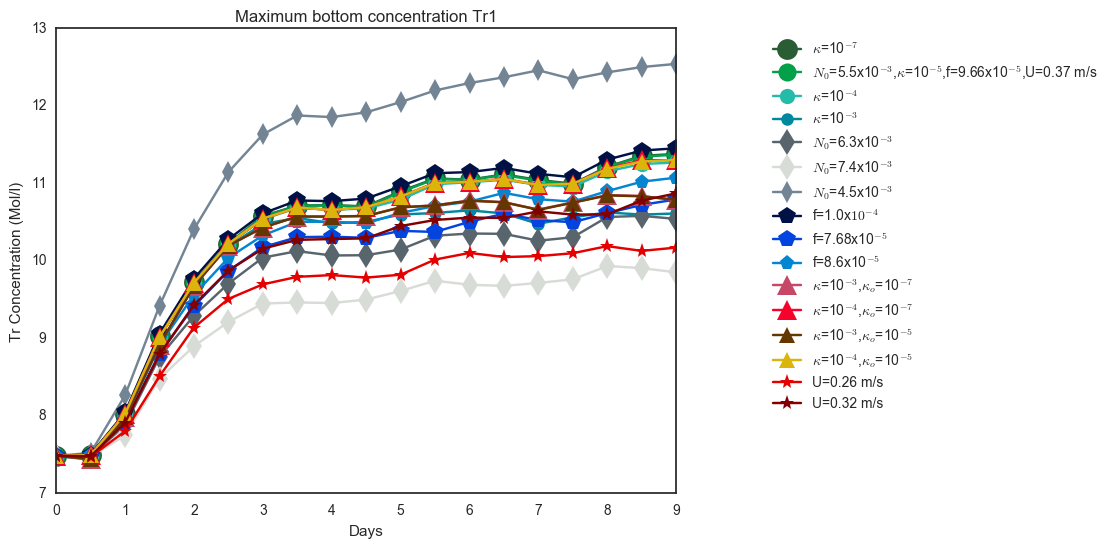

In [15]:
# Choose only the runs that satisfy all restrictions in Allen and Hickey (2010)
records_AH2010 = [CNTDIFF_kv7,
                  CNTDIFF_base, 
                  CNTDIFF_kv4, 
                  CNTDIFF_kv3,
                  CNTDIFF_N63, 
                  CNTDIFF_N74,
                  CNTDIFF_N45,
                  CNTDIFF_f100,
                  CNTDIFF_f76,
                  CNTDIFF_f86,
                  DIFF3D_run04,
                  DIFF3D_run05,
                  DIFF3D_run06,
                  DIFF3D_run07,
                  LOW_BF_u26,
                  LOWER_BF_u32]

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec in records_AH2010:
    
    plt1 = ax.plot(time[:]/(3600*24),rec.max_conc,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
    ax.legend(bbox_to_anchor=(1.7,1))

 
 
ax.set_title('Maximum bottom concentration Tr1')
ax.set_ylabel('Tr Concentration (Mol/l)')
ax.set_xlabel('Days')


plt.show()



### Find depth of upwelling from maximum concentration on shelf bottom

 Since tr profile is linear, we can use the fact that at 2.5 m TrConc is 2 Mol/l and at 1190 m it is 45 Mol/l to
 go from tracer concentration to depth use:
 
 $Z = \frac{1190.0-2.5}{45.0-2.0}(TrConc-2.0)+2.5$


In [16]:
#Check 

TrConc = 3.25
TrDepth = ((1190.0-2.5)/(45.0-2.0))*(TrConc-2.0)+2.5
print('Initial depth of TrConc %f Mol/l is %f m' %(TrConc,TrDepth))


Initial depth of TrConc 3.250000 Mol/l is 37.020349 m


In [17]:
def conc_to_depth(conc,z1=2.5,z2=1190.0,conc1=2.0,conc2=45.0):
    ''' conc: float, the concentration of which to calculate the initial depth
        z1=2.5 m
        z2=1190.0 m
        conc1=2.0 [C]
        conc2=45.0 [C] (default values for tracer profile in base case).
        return: float. Initial depth at which to find concentration conc. 
        Note that depth of upwelling is this depth minus the depth of the canyon head.'''
    
    return(((z2-z1)/(conc2-conc1))*(conc-conc1)+z1)
   

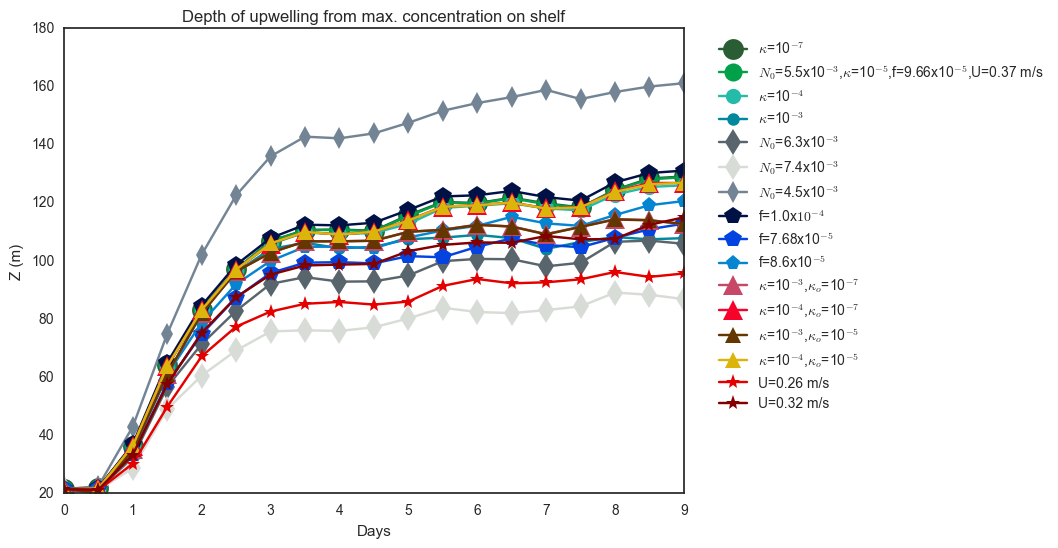

In [18]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_AH2010:
    
    plt1 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc)-Hh,
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()


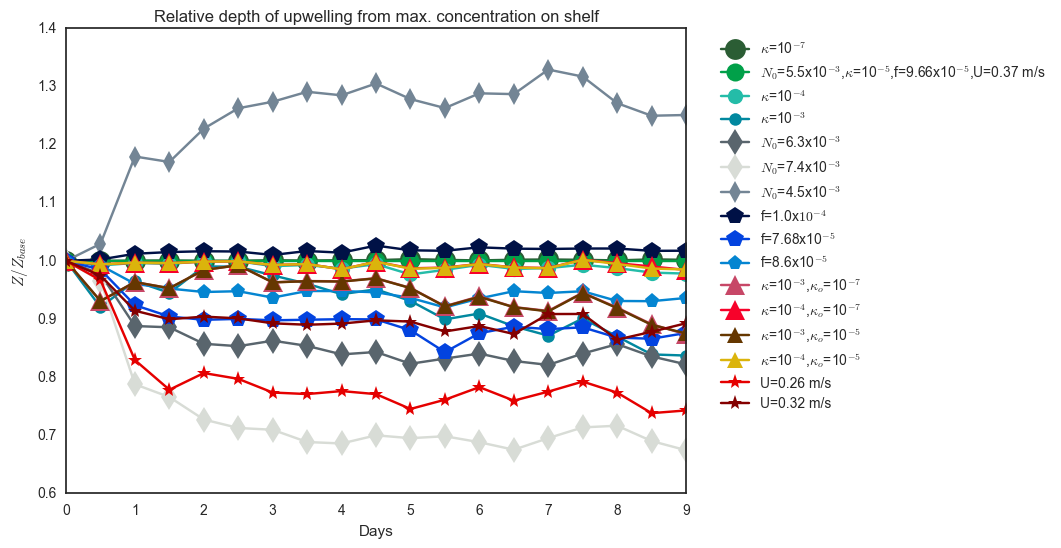

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_AH2010:
    
    plt1 = ax.plot(time[:]/(3600*24),(conc_to_depth(rec.max_conc)-Hh)/(conc_to_depth(CNTDIFF_base.max_conc)-Hh),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Relative depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('$Z/Z_{base}$')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

plt.show()


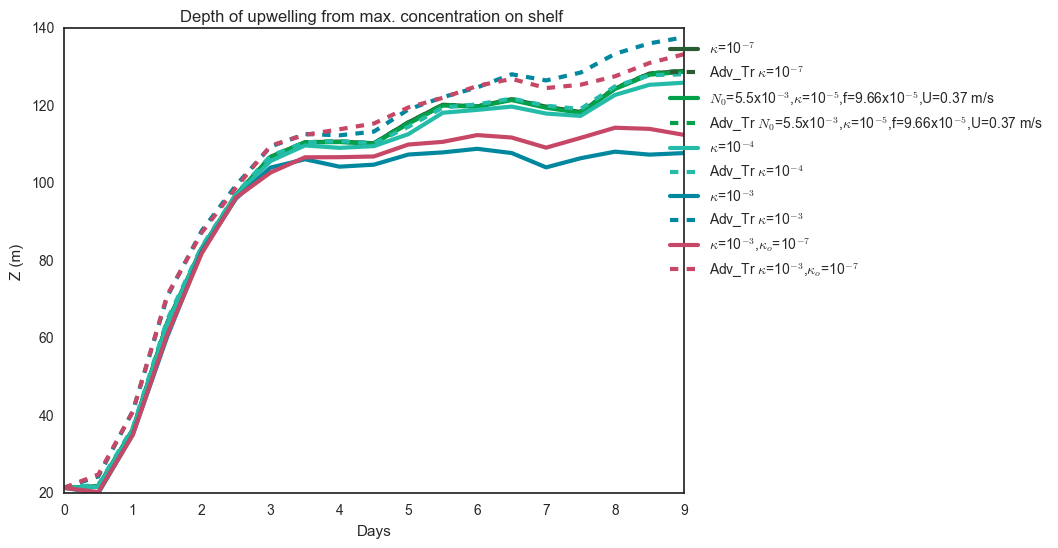

In [20]:
records_Kv = [CNTDIFF_kv7,
              CNTDIFF_base, 
              CNTDIFF_kv4, 
              CNTDIFF_kv3,
              DIFF3D_run04,
              ]

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_Kv:
    
    plt1 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc)-Hh,
                   linestyle='-',
                   linewidth = 3,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    plt2 = ax.plot(time[:]/(3600*24),conc_to_depth(rec.max_conc_adv)-Hh,
                   linestyle='--',
                   linewidth = 3,
                   color = sns.xkcd_rgb[rec.color],
                   label='Adv_Tr %s ' %rec.label)
   
    ax.set_title('Depth of upwelling from max. concentration on shelf ')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))

    
   
plt.show()


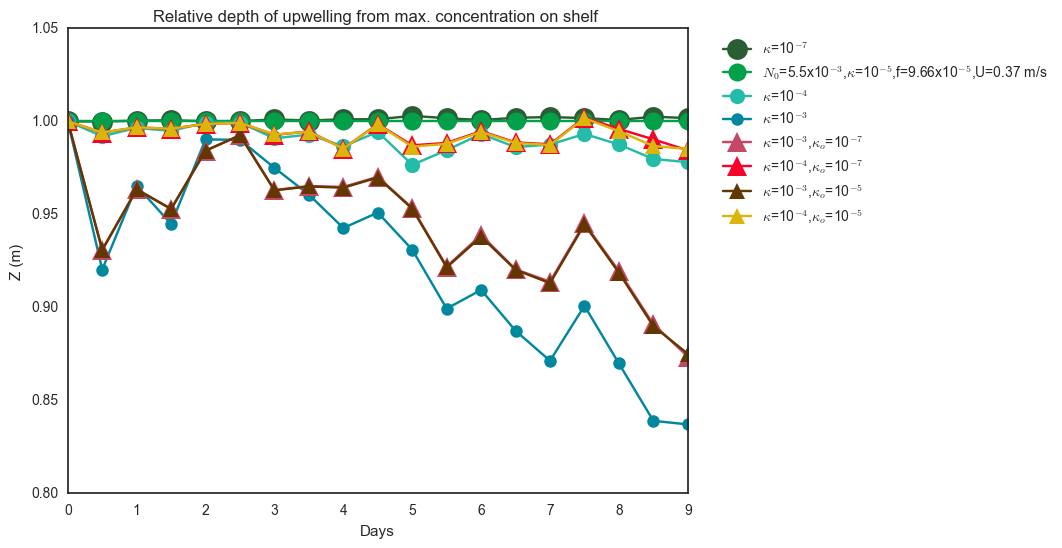

In [21]:
records_Kv = [CNTDIFF_kv7,
             CNTDIFF_base, 
             CNTDIFF_kv4, 
             CNTDIFF_kv3,
             DIFF3D_run04,
             DIFF3D_run05,
             DIFF3D_run06,
             DIFF3D_run07]

fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_Kv:
    
    plt1 = ax.plot(time[:]/(3600*24),(conc_to_depth(rec.max_conc)-Hh)/(conc_to_depth(CNTDIFF_base.max_conc)-Hh),
                   marker = rec.mstyle,
                   markersize = rec.msize,
                   color = sns.xkcd_rgb[rec.color],
                   label=rec.label)
   
    ax.set_title('Relative depth of upwelling from max. concentration on shelf ')
    ax.set_ylabel('Z (m)')
    ax.set_xlabel('Days')

    ax.legend(bbox_to_anchor=(1.6,1))


plt.show()

### Compare measured depth of upwelling to AH2010 and HA2013 estimates

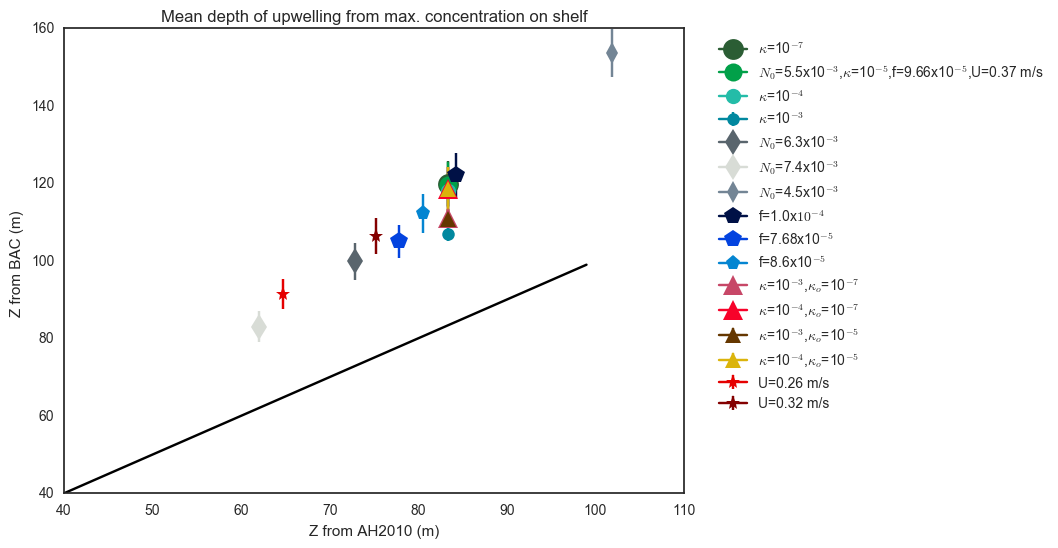

In [22]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_AH2010:
    
    plt1 = ax.errorbar(Z_AH2010(rec.u,L,rec.N,R,rec.f),np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
  
    ax.set_title('Mean depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('Z from BAC (m) ')
    ax.set_xlabel('Z from AH2010 (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


TypeError: 'float' object is not callable

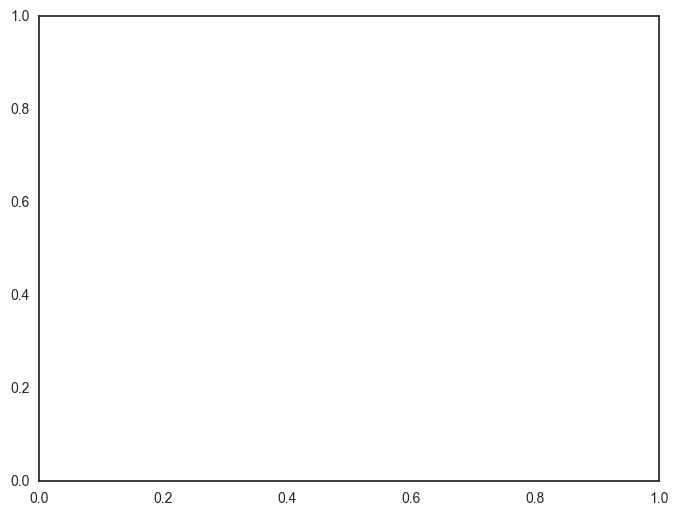

In [26]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_AH2010:
    
    plt1 = ax.errorbar(Z_HA2013(rec.u,L,rec.N,R,rec.f,W,s),
                       np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
  
    ax.set_title('Mean depth of upwelling from max. concentration on shelf')
    ax.set_ylabel('Z from BAC (m) ')
    ax.set_xlabel('Z from AH2010 (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]


for rec in records_AH2010:
    
    plt1 = ax.errorbar(Z(rec.u,L,rec.N,R,rec.f),np.mean(conc_to_depth(rec.max_conc_adv)[8:]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
   
  
    ax.set_title('Mean depth of upwelling from max. concentration adv tracer')
    ax.set_ylabel('Z from BAC (m) ')
    ax.set_xlabel('Z from AH2010 (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


Mean depth of upwelling (mean taken during the advective phase), errorbars correspond to std deviation. The black line is the 1:1 plot of Z. The measured depth of upwelling is about 30 m deeper than the estimated one. This may be because when I look for the bottom concentrations on shelf, the shelf "definition" goes too deep around the rim of the canyon. 

### Depth of upwelling for no canyon cases

In [ ]:
# Save max. tracer concentration per 1/2 day into class record.

for recordNoC in recordsNoC:
    
    filenameNoC=('/ocean/kramosmu/MITgcm/TracerExperiments/%s/%s/ptracersGlob.nc' %(recordNoC.exp_code,recordNoC.run_num))
    TrNoC = rout.getField(filenameNoC,'Tr1') 
    
    ConcFiltSq, AreaSq = ConcArea(TrNoC, hFacCNoC, rA, bathyNoC)
    recordNoC.max_conc = np.max(np.max(ConcFiltSq,1),1)
    

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

records_AH2010_NoC = [CNTDIFF_kv7NoC,
                      CNTDIFF_baseNoC, 
                      CNTDIFF_kv4NoC, 
                      CNTDIFF_kv3NoC,
                      CNTDIFF_N63NoC, 
                      CNTDIFF_N74NoC,
                      CNTDIFF_N45NoC,
                      CNTDIFF_f100NoC,
                      CNTDIFF_f76NoC,
                      CNTDIFF_f86NoC,
                      DIFF3D_run04NoC,
                      DIFF3D_run05NoC,
                      DIFF3D_run06NoC,
                      DIFF3D_run07NoC,
                      LESS_BF_u31NoC,
                      LESS_BF_u20NoC]

for rec in records_AH2010_NoC:
    
    plt1 = ax.errorbar(Z(rec.u,L,rec.N,R,rec.f),np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       np.std(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    ax.set_title('NO CANYON CASES - Mean depth of upwelling from max. concentration on shelf')
    ax.set_xlabel('Z from AH2010 (m) ')
    ax.set_ylabel('Z from BAC (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(40,100),range(40,100),'-k')
    
plt.show()


In [ ]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
labels=[]

for rec,recNoC in zip(records_AH2010,records_AH2010_NoC):
    
    plt1 = ax.plot(np.mean(conc_to_depth(recNoC.max_conc)[8:]-Hh),np.mean(conc_to_depth(rec.max_conc)[8:]-Hh),
                       marker = rec.mstyle,
                       markersize = rec.msize,
                       color = sns.xkcd_rgb[rec.color],
                       label=rec.label)
    
    ax.set_title('Comparison mean depth of upwelling canyon and no canyon cases')
    ax.set_xlabel('Z no canyon (m) ')
    ax.set_ylabel('Z canyon  (m)')

    ax.legend(bbox_to_anchor=(1.6,1))

plt2 = ax.plot(range(30,70),range(30,70),'-k')
    
plt.show()


The depth of upwelling in the canyon base case increases by about 70 m with respect to the no canyon base case when measured using BAC.